In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.optimize import fsolve
from PIL import Image
from scipy.sparse import diags
from scipy.sparse.linalg import factorized

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
def sin(x):
    if isinstance(x, torch.Tensor): 
        return torch.sin(x)
    else:
        return np.sin(x)

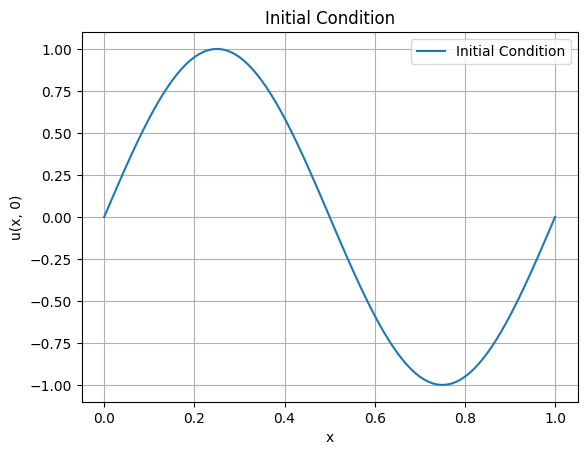

In [4]:
xi, xf, dx = 0, 1, 1e-2
ti, tf, dt = 0, 1, 1e-2

a = 1e-2
x = np.arange(xi, xf + dx, dx, dtype=np.float32)
t = np.arange(ti, tf + dt, dt, dtype=np.float32)
Nx, Nt = len(x), len(t)

T, X = torch.meshgrid(torch.from_numpy(t), torch.from_numpy(x), indexing='ij')
Input_Domain = torch.stack((T.flatten(), X.flatten()), dim=1)

def u0(x):
    return sin(2*np.pi*x)

plt.plot(x, u0(x), label='Initial Condition')
plt.xlabel('x')
plt.ylabel('u(x, 0)')
plt.title('Initial Condition')
plt.legend()
plt.grid()
plt.show()

In [5]:
u = np.zeros((Nt, Nx))
D2 = 1/(dx**2) * diags([1, -2, 1], [-1, 0, 1], shape=(Nx, Nx))
I  = diags([1], [0], shape=(Nx, Nx))

F = a*D2
A = (I - dt/2 * F)
B = (I + dt/2 * F)

solve = factorized(A.tocsc())

for j, tj in enumerate(t):
    if j == 0:
        u[0, :] = u0(x)
    else:
        uj = u[j-1, :]
        u[j, :] = solve(B @ uj)
    
    if np.max(np.abs(u[j, :])) > 1e2:
        print(f"Blow up at time {tj:.3f}s")
        break
    
    if j % int(1/dt * 1e-1) == 0:
        print(f"Time {tj:.3f}s, u_max = {np.max(np.abs(u[j, :])):.3f}")

Time 0.000s, u_max = 1.000
Time 0.100s, u_max = 0.961
Time 0.200s, u_max = 0.924
Time 0.300s, u_max = 0.888
Time 0.400s, u_max = 0.854
Time 0.500s, u_max = 0.821
Time 0.600s, u_max = 0.790
Time 0.700s, u_max = 0.760
Time 0.800s, u_max = 0.732
Time 0.900s, u_max = 0.704
Time 1.000s, u_max = 0.678


In [6]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, u):
        u = self.fcs(u)
        u = self.fch(u)
        u = self.fce(u)
        return u

In [7]:
learning_rate = 1e-3
gamma         = 0.85
epochs        = 20_000 + 1
w_PDE         = 1e-1
w_initial     = 1e1
w_boundary    = 1e-2
N_phys        = 200

N_layers = 7
N_nodes  = 80

In [8]:
initial_x = torch.linspace(xi, xf, 20)
input_initial   = torch.stack((t[0]*torch.ones_like(initial_x), initial_x), dim=1)

boundary_t = torch.linspace(ti, tf, 50)
input_boundary1 = torch.stack((boundary_t, x[0]*torch.ones_like(boundary_t)), dim=1)
input_boundary2 = torch.stack((boundary_t, x[-1]*torch.ones_like(boundary_t)), dim=1)

t_col = torch.linspace(ti, tf, 50)
x_col = torch.linspace(xi, xf, 50)

Tc, Xc = torch.meshgrid(t_col, x_col, indexing='ij')
input_pde = torch.stack((Tc.flatten(), Xc.flatten()), dim=1).requires_grad_(True)

In [9]:
def training_plot(save=False, file_name=""):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
    axs[0, 0].plot(x, p[0, :], c='blue')
    axs[0, 0].plot(x, u[0, :], c="gray", linestyle='--')
    
    titles = ['t = 0', 't=0.25', 't = 0.5', 't = 1']
    time_indecies = [0, int(Nt/3), int(Nt*2/3), Nt-1]
    for j, ax in enumerate(axs.flat):
        tj = time_indecies[j]
        ax.plot(x, p[tj, :], c='blue')
        ax.plot(x, u[tj, :], c="gray", linestyle='--')
        ax.set_title(f"Time = {t[tj]:.2f}s")
        ax.grid()
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(xi, xf)
        
    fig.suptitle(f"Epoch: {i}")
    
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

Epoch: 0, Loss: 4.7727, MSE: 0.3511


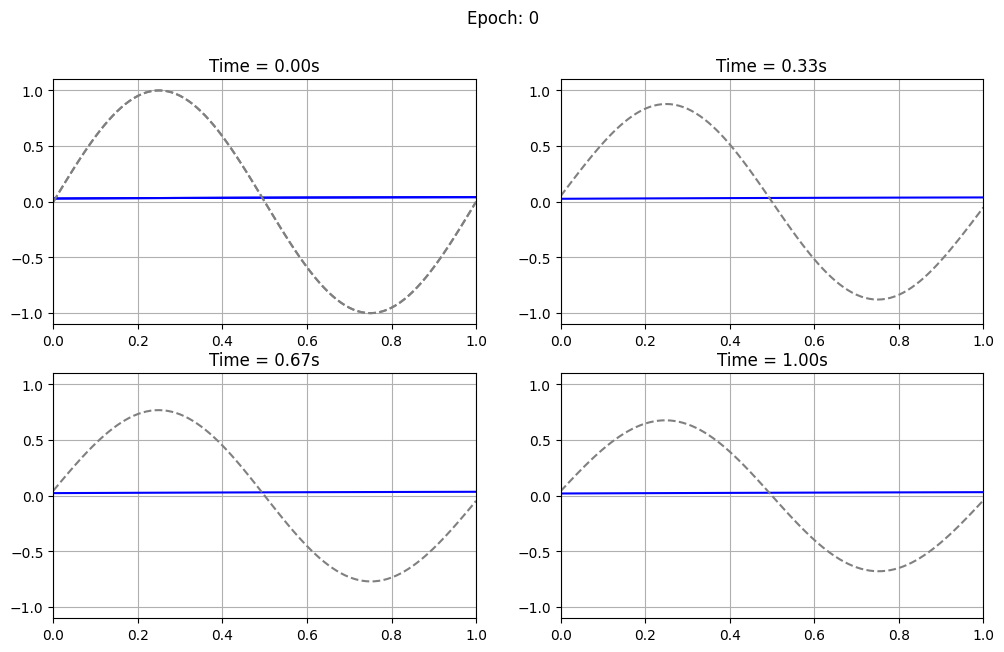

Epoch: 1000, Loss: 4.7500, MSE: 0.3468


In [ ]:
PINN = FCN(2, 1, N_nodes, N_layers)
optimizer = torch.optim.Adam(PINN.parameters(), lr = learning_rate)

mse_history  = []
loss_history = []

for i in range(epochs):
    PINN.train()
    optimizer.zero_grad()
    
    # Initial Loss
    loss_initial = torch.mean((PINN(input_initial) - u0(input_initial[:, 1]))**2)
    
    # Boundary Loss
    loss_boundary1 = torch.mean(PINN(input_boundary1)**2)
    loss_boundary2 = torch.mean(PINN(input_boundary2)**2)
    loss_boundary  = loss_boundary1 + loss_boundary2
    
    # PDE Loss
    v  = PINN(input_pde)
    Dv = torch.autograd.grad(v, input_pde, torch.ones_like(v), create_graph=True)[0]
    
    v_t  = Dv[:, 0:1]
    v_x  = Dv[:, 1:2]
    v_xx = torch.autograd.grad(v_x, input_pde, torch.ones_like(v_x), create_graph=True)[0][:, 1:2]
    
    loss_pde = torch.mean((v_t - a*v_xx)**2)

    # Total Loss
    loss = w_initial*loss_initial + w_boundary*loss_boundary + w_PDE*loss_pde
    
    loss.backward()
    optimizer.step()
    
    PINN.eval()
    
    p = PINN(Input_Domain).detach().numpy().reshape(Nt, Nx)
    MSE = np.mean((u - p)**2)
    
    mse_history.append(MSE)
    loss_history.append(loss.item())
    
    if i % 1000 == 0:
        print(f"Epoch: {i}, Loss: {loss.item():.4f}, MSE: {MSE:.4f}")
        if i % 5000 == 0:
            training_plot()
            plt.show()
    

In [ ]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", ti=0):
    fig, ax = plt.subplots()
    ax.plot(x, u[i, :], label='Numerical Solution Solution', linestyle='--', c="gray")
    ax.plot(x, p[i, :], label='PINN Solution', c="blue")
    ax.set_xlim(xi, xf)
    ax.set_ylim(-1.05, 1.05)
    ax.grid()
    ax.set_title(f"Time = {ti:.3f}s")
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [ ]:
import os
import shutil

folder_path="PINN_plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [ ]:
files = []
fps   = 20
frame_indicies = np.linspace(0, Nt-1, int(fps*t[-1]), dtype=int)
for i in frame_indicies:
    tj = t[i]
    file = f"PINN_plots/PDE_sol_{tj:.5f}.png"
    make_plot(save=True, file_name=file, ti=tj)
    files.append(file)
    plt.close("all")
    
save_gif_PIL("PINN_Comparison.gif", files, fps=fps, loop=0)

KeyboardInterrupt: 

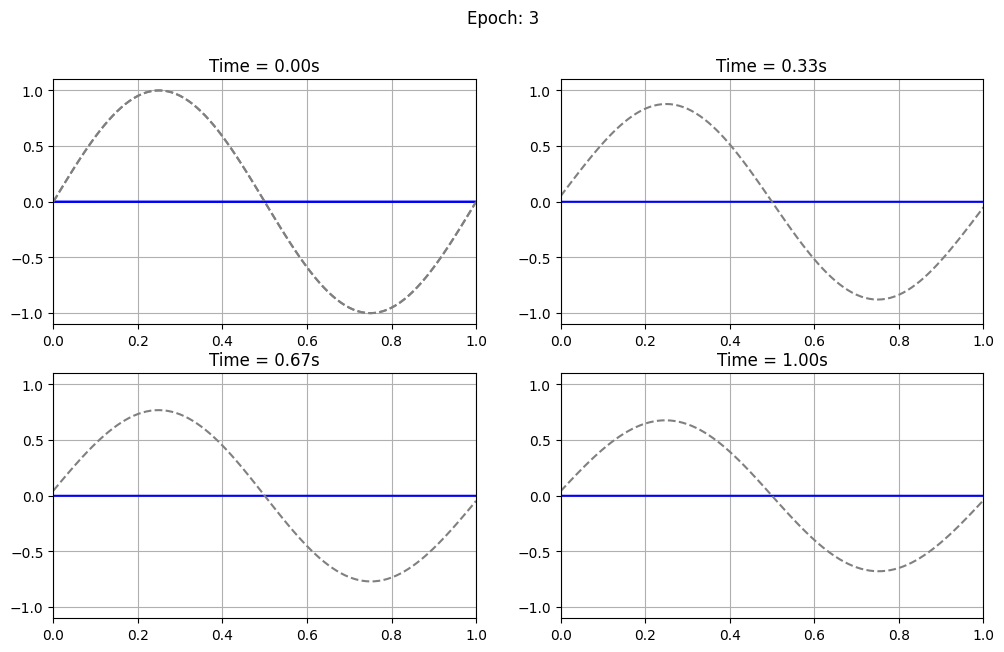

In [ ]:
files = []
fps   = 20
frame_indicies = np.linspace(0, epochs, int(fps*10), dtype=int)
for i in frame_indicies:
    tj = t[j]
    file = f"PINN_plots/PDE_Epochs_{tj:.5f}.png"
    training_plot(save=True, file_name=file)
    files.append(file)
    plt.close("all")
    
save_gif_PIL("PINN_Comparison.gif", files, fps=fps, loop=0)